# Libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyglet

import cv2

from facenet_pytorch import MTCNN

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision.transforms as tt
from torchvision.datasets import ImageFolder

# Base vars

In [2]:
ROOT_EMO = '../data/faces/'
ROOT_GEST = '..\\data\\leapGestRecog'

PATH_TO_MODEL_EMO = '../models/emotion_detection_model_state.pth'
PATH_TO_MODEL_GEST = '..\\models\\gesture_detection_model_state.pth'

CLASSES_EMO = 'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'
CLASSES_GEST = 'fist', 'no_gest', 'ok', 'palm'

SOURSE = '../data/test.mp4'

BATCH_SIZE = 8
IMG_SIZE = 64

In [3]:
player = pyglet.media.Player() # create players
sound = pyglet.media.load('../data/Animal Джаz - Чувства.mp3') # load sound

player.queue(sound) # sound in player

# Model

In [4]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 128)
        self.conv2 = self.conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(
            self.conv_block(128, 128), 
            self.conv_block(128, 128)
        ) # Sequential
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(
            self.conv_block(256, 256), 
            self.conv_block(256, 256)
        ) # Sequential
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(256, 512)
        self.conv6 = self.conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(
            self.conv_block(512, 512), 
            self.conv_block(512, 512)
        ) # Sequential
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(
            nn.MaxPool2d(6), 
            nn.Flatten(),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        ) # Sequential
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: 
            layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

# Load state to model

In [5]:
with torch.no_grad():
    modelEMO = ResNet(1, len(CLASSES_EMO))
    modelEMO.load_state_dict(torch.load(PATH_TO_MODEL_EMO))
    modelEMO.eval()
    
    modelGEST = ResNet(1, len(CLASSES_GEST))
    modelGEST.load_state_dict(torch.load(PATH_TO_MODEL_GEST))
    modelGEST.eval()

In [6]:
# Класс детектирования и обработки лица с веб-камеры 
class FaceDetector(object):
    
    def __init__(self, mtcnn, emodel, gmodel, classes_emo, classes_gest, source, player):
        # Создаем объект для считывания потока с веб-камеры(обычно вебкамера идет под номером 0. иногда 1)
        self.cap = cv2.VideoCapture(source)
        self.mtcnn = mtcnn
        self.emodel = emodel
        self.gmodel = gmodel
        self.classes_emo = classes_emo
        self.classes_gest = classes_gest
        self.player = player

    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, boxes, probs, landmarks, emotion, gest):
        try:
            for box, prob, ld in zip(boxes, probs, landmarks):
                # Рисуем обрамляющий прямоугольник лица на кадре
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                # пишем на кадре какая эмоция распознана
                cv2.putText(frame, emotion, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        except:
            pass

        return frame
    
    # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(
                frame[
                    int(box[1]-40):int(box[3]+40), 
                    int(box[0]-40):int(box[2]+40)
                ] # frame
            ) # append
        return faces
       
    # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):              
        # Заходим в бесконечный цикл
        while True:
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
            ret, frame = self.cap.read()
            try:
                # детектируем расположение лица на кадре, вероятности на сколько это лицо
                # и особенные точки лица
                boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)

                if probs[0]: # если лицо есть
                    gframe = cv2.resize(frame[..., 0], (IMG_SIZE, IMG_SIZE)) # фрейм меняет размер [64, 64]
                    gframe = torch.from_numpy(gframe) # переводится в тип tensor
                    gframe = gframe[None, None].float() # добаляются еще 2 мерности и значения переводятся в тип float
                    gest = self.gmodel(gframe)[0] # прогноз модели
                    gest = self.classes_gest[gest.argmax()] # название жеста
                    cv2.putText(frame, gest, (0, 450), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                    
                    if gest == 'palm':
                        self.player.play()
                    elif gest == 'fist':
                        self.player.pause()
                
                # Вырезаем лицо из кадра
                face = self.crop_faces(frame, boxes)[0]
                # Меняем размер изображения лица для входа в нейронную сеть
                face = cv2.resize(face, (48, 48))
                # Превращаем в 1-канальное серое изображение
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                # Превращаем numpy-картинку вырезанного лица в pytorch-тензор
                torch_face = torch.from_numpy(face).unsqueeze(0).float()
                # Загужаем наш тензор лица в нейронную сеть и получаем предсказание
                emotion = self.emodel(torch_face[None, ...])
                # Интерпретируем предсказание как строку нашей эмоции
                emotion = emotion[0].argmax().item() # индекс эмоции
                emotion = self.classes_emo[emotion]  # название эмоции

                # Рисуем на кадре
                self._draw(frame, boxes, probs, landmarks, emotion, gest)
                
                cv2.imshow("Gray face", face)

            except Exception as e:
                pass

            # Показываем кадр в окне, и назвываем его(окно) - 'Face Detection'
            cv2.imshow('Face Detection', frame)

            # Функция, которая проверяет нажатие на клавишу 'q'
            # Если нажатие произошло - выход из цикла. Конец работы приложения
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        # Очищаем все объекты opencv, что мы создали
        self.cap.release()
        cv2.destroyAllWindows()

In [7]:
# Создаем объект нашего класса приложения
fcd = FaceDetector(mtcnn=MTCNN(), 
                   emodel=modelEMO, gmodel=modelGEST, 
                   classes_emo=CLASSES_EMO, classes_gest=CLASSES_GEST,  
                   source=SOURSE, player=player)
# Запускаем
fcd.run()

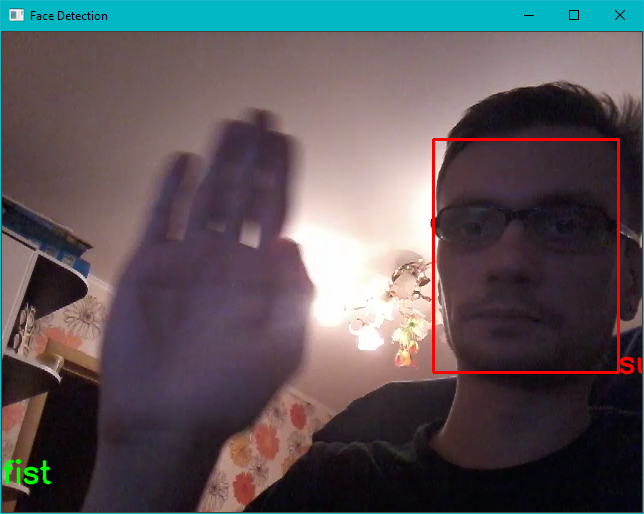